# "Simple Linear Regression"

Step 1: Instantiate pyspark 

Convention_installation

In [1]:
# Install all the dependencies in Colab environment i.e. Apache Spark 3.2.1 with hadoop 2.7, Java 8 and Findspark to locate the spark in the system
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz
!tar xf spark-3.2.1-bin-hadoop2.7.tgz
!pip install -q findspark

In [2]:
# Setup Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop2.7"

In [3]:
# Start Spark Session
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

Clean_Installation

In [1]:
!pip install pyspark py4j

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

Step 2: Data Import and feature Transform

In [3]:
data = spark.read.csv('/content/Student_Grades_Data.csv', header=True, inferSchema=True)

In [4]:
#Taking a look at data type of each column to see what data types inferSchema=TRUE paramter has set for each column
data.printSchema()

root
 |-- Time_to_Study: integer (nullable = true)
 |-- Grades: double (nullable = true)



In [5]:
data.show()

+-------------+------+
|Time_to_Study|Grades|
+-------------+------+
|            1|   1.5|
|            5|   2.7|
|            7|   3.1|
|            3|   2.1|
|            2|   1.8|
|            9|   3.9|
|            6|   2.9|
|           12|   4.5|
|           11|   4.3|
|            2|   1.8|
|            4|   2.4|
|            8|   3.5|
|           13|   4.8|
|            9|   3.9|
|           14|   5.0|
|           10|   4.1|
|            6|   2.9|
|           12|   4.5|
|            1|   1.5|
|            4|   2.4|
+-------------+------+
only showing top 20 rows



Vector Assembler (feature Transform)

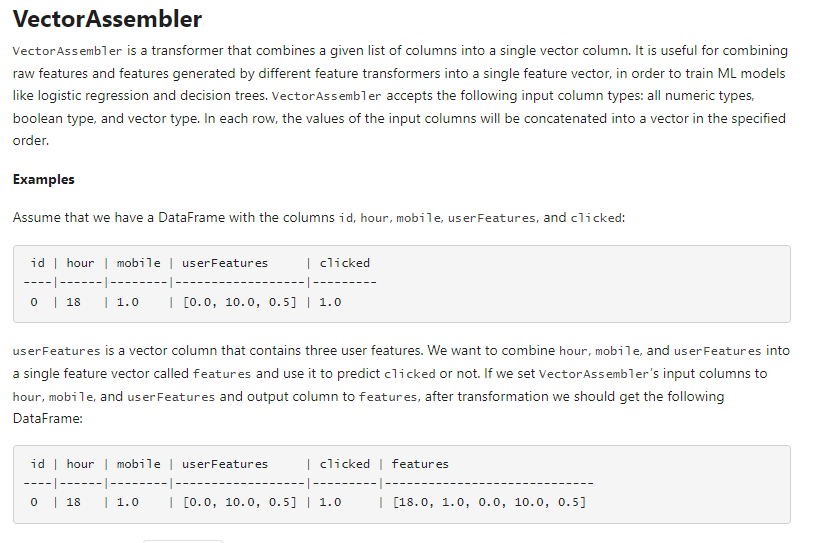

In [6]:
#Create a Feature array by omitting the last column
feature_cols = data.columns[:-1] 
from pyspark.ml.feature import VectorAssembler
vect_assembler = VectorAssembler(inputCols=feature_cols,outputCol="features")

In [7]:
#Utilize Assembler created above in order to add the feature column
data_w_features = vect_assembler.transform(data)

In [8]:
#Display the data having additional column named features. Had it been multiple linear regression problem, you could see all the
# independent variable values combined in one list
data_w_features.show()

+-------------+------+--------+
|Time_to_Study|Grades|features|
+-------------+------+--------+
|            1|   1.5|   [1.0]|
|            5|   2.7|   [5.0]|
|            7|   3.1|   [7.0]|
|            3|   2.1|   [3.0]|
|            2|   1.8|   [2.0]|
|            9|   3.9|   [9.0]|
|            6|   2.9|   [6.0]|
|           12|   4.5|  [12.0]|
|           11|   4.3|  [11.0]|
|            2|   1.8|   [2.0]|
|            4|   2.4|   [4.0]|
|            8|   3.5|   [8.0]|
|           13|   4.8|  [13.0]|
|            9|   3.9|   [9.0]|
|           14|   5.0|  [14.0]|
|           10|   4.1|  [10.0]|
|            6|   2.9|   [6.0]|
|           12|   4.5|  [12.0]|
|            1|   1.5|   [1.0]|
|            4|   2.4|   [4.0]|
+-------------+------+--------+
only showing top 20 rows



In [9]:
#Select only Features and Label from previous dataset as we need these two entities for building machine learning model
finalized_data = data_w_features.select("features","Grades")

finalized_data.show()

+--------+------+
|features|Grades|
+--------+------+
|   [1.0]|   1.5|
|   [5.0]|   2.7|
|   [7.0]|   3.1|
|   [3.0]|   2.1|
|   [2.0]|   1.8|
|   [9.0]|   3.9|
|   [6.0]|   2.9|
|  [12.0]|   4.5|
|  [11.0]|   4.3|
|   [2.0]|   1.8|
|   [4.0]|   2.4|
|   [8.0]|   3.5|
|  [13.0]|   4.8|
|   [9.0]|   3.9|
|  [14.0]|   5.0|
|  [10.0]|   4.1|
|   [6.0]|   2.9|
|  [12.0]|   4.5|
|   [1.0]|   1.5|
|   [4.0]|   2.4|
+--------+------+
only showing top 20 rows



Step3: Train_test_split

In [10]:
#Split the data into training and test model with 70% obs. going in training and 30% in testing
train_dataset, test_dataset = finalized_data.randomSplit([0.7, 0.3])

In [11]:
#Peek into training data
train_dataset.describe().show()

+-------+------------------+
|summary|            Grades|
+-------+------------------+
|  count|                32|
|   mean| 3.306249999999999|
| stddev|1.0755156302758888|
|    min|               1.5|
|    max|               5.0|
+-------+------------------+



In [12]:
#Peek into test_dataset
test_dataset.describe().show()

+-------+------------------+
|summary|            Grades|
+-------+------------------+
|  count|                18|
|   mean|3.0722222222222224|
| stddev|1.1711259316198315|
|    min|               1.5|
|    max|               5.0|
+-------+------------------+



Step 4: Model Training

In [13]:
#Import Linear Regression class called LinearRegression
from pyspark.ml.regression import LinearRegression

In [14]:
#Create the Linear Regression object named having feature column as features and Label column as Time_to_Study
LinReg = LinearRegression(featuresCol="features", labelCol="Grades")

In [15]:
#Train the model on the training using fit() method.
model = LinReg.fit(train_dataset)

In [16]:
#Predict the Grades using the evulate method
pred = model.evaluate(test_dataset)

In [17]:
#Show the predicted Grade values along side actual Grade values
pred.predictions.show()

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


+--------+------+------------------+
|features|Grades|        prediction|
+--------+------+------------------+
|   [1.0]|   1.5|1.5701713395638577|
|   [1.0]|   1.5|1.5701713395638577|
|   [1.0]|   1.5|1.5701713395638577|
|   [2.0]|   1.8|1.8424974039459976|
|   [3.0]|   2.1|2.1148234683281375|
|   [4.0]|   2.4| 2.387149532710277|
|   [4.0]|   2.4| 2.387149532710277|
|   [6.0]|   2.9| 2.931801661474557|
|   [7.0]|   3.1|3.2041277258566967|
|   [7.0]|   3.1|3.2041277258566967|
|   [7.0]|   3.1|3.2041277258566967|
|   [8.0]|   3.5|3.4764537902388364|
|   [8.0]|   3.5|3.4764537902388364|
|  [10.0]|   4.1| 4.021105919003116|
|  [11.0]|   4.3| 4.293431983385256|
|  [12.0]|   4.5| 4.565758047767396|
|  [14.0]|   5.0| 5.110410176531675|
|  [14.0]|   5.0| 5.110410176531675|
+--------+------+------------------+



In [18]:
#Find out coefficient value
coefficient = model.coefficients
print ("The coefficient of the model is : %a" %coefficient)

The coefficient of the model is : DenseVector([0.2723])


In [19]:
#Find out intercept Value
intercept = model.intercept
print ("The Intercept of the model is : %f" %intercept)

The Intercept of the model is : 1.297845


In [20]:
#Evaluate the model using metric like Mean Absolute Error(MAE), Root Mean Square Error(RMSE) and R-Square
from pyspark.ml.evaluation import RegressionEvaluator
evaluation = RegressionEvaluator(labelCol="Grades", predictionCol="prediction")

# Root Mean Square Error
rmse = evaluation.evaluate(pred.predictions, {evaluation.metricName: "rmse"})
print("RMSE: %.3f" % rmse)

# Mean Square Error
mse = evaluation.evaluate(pred.predictions, {evaluation.metricName: "mse"})
print("MSE: %.3f" % mse)

# Mean Absolute Error
mae = evaluation.evaluate(pred.predictions, {evaluation.metricName: "mae"})
print("MAE: %.3f" % mae)

# r2 - coefficient of determination
r2 = evaluation.evaluate(pred.predictions, {evaluation.metricName: "r2"})
print("r2: %.3f" %r2)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


RMSE: 0.069
MSE: 0.005
MAE: 0.059
r2: 0.996
